# Imports

In [1]:



import copy
import tensorflow as tf
import random
import time
import numpy as np
from keras.datasets import mnist
import sys
import os
import itertools
import sklearn.cluster
import scipy.misc
from time import time 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib



# Define variables

In [8]:


perturbation_count_train_arr=[]
i=0
while i<=60000:
    perturbation_count_train_arr.append(i)
    i+=10000
    


epsilon=0.3

batch_size=1024
epochs=20
filters=32
kernel_size=3



# Create and train a model

In [3]:
#ResNet implementation
def create_and_train_model():
      (x_train, y_train), (x_test, y_test) = mnist.load_data()

      img_rows = img_cols = 28
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')
      x_train /= 255
      x_test /= 255

      model = Sequential()
      model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
      model.add(MaxPooling2D((2, 2)))
      model.add(Conv2D(filters*2, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_uniform'))
      model.add(Conv2D(filters*2, (kernel_size, kernel_size), activation='relu', kernel_initializer='he_uniform'))
      model.add(MaxPooling2D((2, 2)))
      model.add(Flatten())
      model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(10, activation='softmax'))
	# compile model
	
      model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

      history=model.fit(x_train,to_categorical(y_train, 10),
                  batch_size=batch_size,
                  epochs=epochs,
                  shuffle=True,
                  verbose=2,
                  )


      # plt.plot(history.history['accuracy'])
      # plt.xlabel('Epoch')
      # plt.ylabel('Accuracy')
      # print('Training time:',time()-begin)
      
      return model
    

final=create_and_train_model()
final.save("vanilla_model")







Epoch 1/20
59/59 - 4s - loss: 0.6588 - accuracy: 0.8109 - 4s/epoch - 60ms/step
Epoch 2/20
59/59 - 1s - loss: 0.1049 - accuracy: 0.9683 - 982ms/epoch - 17ms/step
Epoch 3/20
59/59 - 1s - loss: 0.0727 - accuracy: 0.9775 - 1s/epoch - 17ms/step
Epoch 4/20
59/59 - 1s - loss: 0.0562 - accuracy: 0.9826 - 1s/epoch - 17ms/step
Epoch 5/20
59/59 - 1s - loss: 0.0472 - accuracy: 0.9855 - 1s/epoch - 17ms/step
Epoch 6/20
59/59 - 1s - loss: 0.0385 - accuracy: 0.9881 - 1s/epoch - 17ms/step
Epoch 7/20
59/59 - 1s - loss: 0.0320 - accuracy: 0.9901 - 1s/epoch - 17ms/step
Epoch 8/20
59/59 - 1s - loss: 0.0275 - accuracy: 0.9915 - 983ms/epoch - 17ms/step
Epoch 9/20
59/59 - 1s - loss: 0.0260 - accuracy: 0.9921 - 1s/epoch - 17ms/step
Epoch 10/20
59/59 - 1s - loss: 0.0215 - accuracy: 0.9937 - 1000ms/epoch - 17ms/step
Epoch 11/20
59/59 - 1s - loss: 0.0189 - accuracy: 0.9941 - 983ms/epoch - 17ms/step
Epoch 12/20
59/59 - 1s - loss: 0.0167 - accuracy: 0.9951 - 983ms/epoch - 17ms/step
Epoch 13/20
59/59 - 1s - loss: 0.

# Generate perturbation-based adversarial examples on test images (LinfPGD)


In [5]:
from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

print("Tensorflow version: ",tf.__version__)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


x_test = x_test.astype('float32')
x_test /= 255

model=load_model("vanilla_model")




#assign model to foolbox
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))


# converting test data to type tensor

x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)

attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(abs_stepsize=0.01)

#Adversarial examples to test...
_,advs_to_test, success=attack(fmodel, x_attack_to_test, y_attack_to_test, epsilons=epsilon)

# with tf.Session() as sess:  print(product.eval()) 
#HIER IMMER WIEDER ATTACKE MACHEN WEILS WHITE BOX IS!!!!!
successes=0
fails=0
for i in range(len(success)):
    if(tf.keras.backend.get_value(success[i])==True):
        successes+=1
    else:
        fails+=1
  
    
print("Complete count: ",fails+successes)
print("Fails: ",fails/(fails+successes))
print("Successes: ",successes/(fails+successes))
# print("SUCCESS: ",success)
print(np.shape(advs_to_test))

np.save("data/perturbation_based_adv_examples/test_LinfPGD", advs_to_test)





Tensorflow version:  2.7.0
Complete count:  10000
Fails:  0.0
Successes:  1.0
(10000, 28, 28, 1, 1)


# Generate perturbation-based adversarial examples on train images (LinfPGD, perturbation_count_train)


In [6]:
from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)


x_train = x_train.astype('float32')

x_train /= 255


model=load_model("vanilla_model")




#assign model to foolbox
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))



#converting training data to type tensor
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(abs_stepsize=0.01)

#Generate perturbation-based adversarial examples to train...
print("generating 60000 adversarial examples...")

    

_,advs, success=attack(fmodel, x_attack_to_train[0:10000], y_attack_to_train[0:10000], epsilons=epsilon)
print("10000...")
_,advs1, success=attack(fmodel, x_attack_to_train[10000:10000*2], y_attack_to_train[10000:10000*2], epsilons=epsilon)   
print("20000...")   
_,advs2, success=attack(fmodel, x_attack_to_train[10000*2:10000*3], y_attack_to_train[10000*2:10000*3], epsilons=epsilon)
print("30000...")      
_,advs3, success=attack(fmodel, x_attack_to_train[10000*3:10000*4], y_attack_to_train[10000*3:10000*4], epsilons=epsilon)
print("40000...")    
_,advs4, success=attack(fmodel, x_attack_to_train[10000*4:10000*5], y_attack_to_train[10000*4:10000*5], epsilons=epsilon)
print("50000...")   
_,advs5, success=attack(fmodel, x_attack_to_train[10000*5:10000*6], y_attack_to_train[10000*5:10000*6], epsilons=epsilon) 
print("60000...")   
advs_to_train=tf.concat([advs,advs1, advs2, advs3, advs4, advs5],0)
print(np.shape(advs_to_train))



np.save("data/perturbation_based_adv_examples/train_LinfPGD", advs_to_train)

generating 60000 adversarial examples...
10000...
20000...
30000...
40000...
50000...
60000...
(60000, 28, 28, 1, 1)


# Attack Vanilla Model and Retrain with adversarial examples

313/313 [==============================] - 1s 4ms/step - loss: 0.0274 - accuracy: 0.9923
Test accuracy on clean testing data 0.9922999739646912
313/313 [==============================] - 1s 3ms/step - loss: 18.8995 - accuracy: 0.0000e+00
(60000,)
(60000, 28, 28, 1, 1)
retraining model...
Epoch 1/20
10/10 [==============================] - 1s 56ms/step - loss: 6.5405 - accuracy: 0.2803
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 1.6697 - accuracy: 0.5116
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 1.0100 - accuracy: 0.6959
Epoch 4/20
10/10 [==============================] - 0s 18ms/step - loss: 0.6626 - accuracy: 0.7869
Epoch 5/20
10/10 [==============================] - 0s 18ms/step - loss: 0.5183 - accuracy: 0.8329
Epoch 6/20
10/10 [==============================] - 0s 18ms/step - loss: 0.4168 - accuracy: 0.8684
Epoch 7/20
10/10 [==============================] - 0s 18ms/step - loss: 0.3462 - accuracy: 0.8952
Epoch 8/20
10/10 [

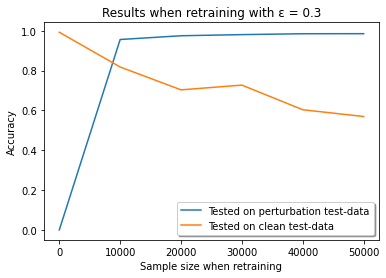

Epoch 1/20
49/49 [==============================] - 1s 21ms/step - loss: 2.0807 - accuracy: 0.6139
Epoch 2/20
49/49 [==============================] - 1s 18ms/step - loss: 0.3343 - accuracy: 0.8976
Epoch 3/20
49/49 [==============================] - 1s 18ms/step - loss: 0.1880 - accuracy: 0.9442
Epoch 4/20
49/49 [==============================] - 1s 18ms/step - loss: 0.1321 - accuracy: 0.9606
Epoch 5/20
49/49 [==============================] - 1s 18ms/step - loss: 0.0991 - accuracy: 0.9699
Epoch 6/20
49/49 [==============================] - 1s 18ms/step - loss: 0.0804 - accuracy: 0.9749
Epoch 7/20
49/49 [==============================] - 1s 18ms/step - loss: 0.0667 - accuracy: 0.9796
Epoch 8/20
49/49 [==============================] - 1s 18ms/step - loss: 0.0554 - accuracy: 0.9840
Epoch 9/20
49/49 [==============================] - 1s 18ms/step - loss: 0.0460 - accuracy: 0.9864
Epoch 10/20
49/49 [==============================] - 1s 18ms/step - loss: 0.0406 - accuracy: 0.9874
Epoch 11/

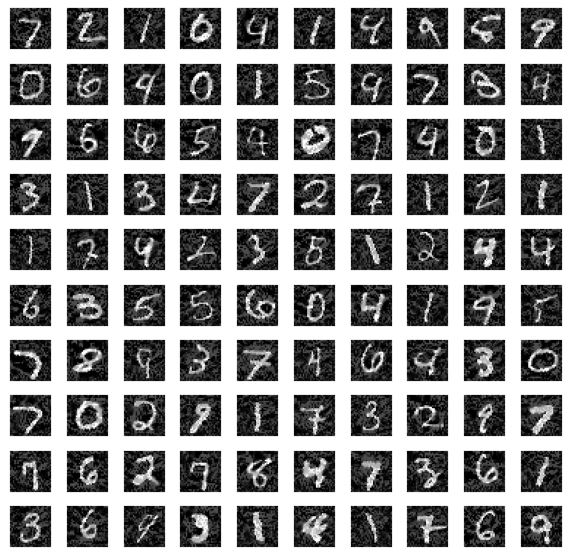

In [9]:

from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


advs_to_test=np.load("data/perturbation_based_adv_examples/test_LinfPGD.npy")
advs_to_retrain=np.load("data/perturbation_based_adv_examples/train_LinfPGD.npy")
model=load_model("vanilla_model")




(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test = x_test.astype('float32')
x_test /= 255





#Retrain Models and evaluate if the number of examples to retrain makes a difference on the clean accuracy and the accuracy against perturbation
results_clean=[]
results_perturbation=[]
successful_attacks=[1]
acc = model.evaluate(x_test, to_categorical(y_test))
results_clean.append(acc[1])
print('VANILLA: Test accuracy on clean testing data', acc[1])
acc = model.evaluate(advs_to_test, to_categorical(y_test))
print('VANILA: Test accuracy on  perturbation-based adversarial examples:', acc[1])
results_perturbation.append(acc[1])
print(np.shape(y_train))
print(np.shape(advs_to_retrain))


for i in range(len(perturbation_count_train_arr)):

    if i>0:

        #get saved model
        model1=load_model("vanilla_model")

        #retrain model with perturbation-based adversarial examples
        print("retraining model...")
        model1.fit(advs_to_retrain[0:perturbation_count_train_arr[i]],to_categorical(y_train[0:perturbation_count_train_arr[i]]),
            batch_size=batch_size,
            epochs=epochs,
            )
        print("Retrained model with ",perturbation_count_train_arr[i], " perturbation-based adversarial examples")
        
       
        # Test model against clean test data. Use fixed sample size on testing...
        acc = model1.evaluate(x_test, to_categorical(y_test))
        results_clean.append(acc[1])
        print('Test accuracy on clean testing data', acc[1])

        
        # Test model against perturbation-based adversarial examples. Use fixed sample size on testing...
        acc = model1.evaluate(advs_to_test, to_categorical(y_test))
        print('Test accuracy on perturbation based adversarial examples', acc[1])
        results_perturbation.append(acc[1])


#plot results
fig, ax = plt.subplots()
# fig.set_size_inches(15,15)
ax.plot(perturbation_count_train_arr,results_perturbation, label='Tested on perturbation test-data')
ax.plot(perturbation_count_train_arr,results_clean, label='Tested on clean test-data')

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.xlabel('Sample size when retraining')
plt.ylabel('Accuracy')
plt.title("Results when retraining with ε = {}".format(epsilon))
plt.show()





#Retrain and save as ptb_trained model
model.fit(advs_to_retrain[0:perturbation_count_train_arr[i]],to_categorical(y_train[0:perturbation_count_train_arr[i]]),
            batch_size=batch_size,
            epochs=epochs,
            )
acc = model.evaluate(x_test, to_categorical(y_test))
print('PTB_TRAINED: Test accuracy on clean testing data', acc[1])
acc = model.evaluate(advs_to_test, to_categorical(y_test))
print('PTB_TRAINED: Test accuracy on  perturbation-based adversarial examples:', acc[1])
model.save("ptb_trained_model")



#plot adversarial images
_, ax = plt.subplots(10, 10, figsize=(10, 10))

for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=advs_to_test[i]
    x=x[:,:,0,0]
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')

plt.show()




# Testing invariance based adversarial examples from paper (100 labels from 40 human participants)


INVARIANCE BASED ADVERSARIAL IMAGES


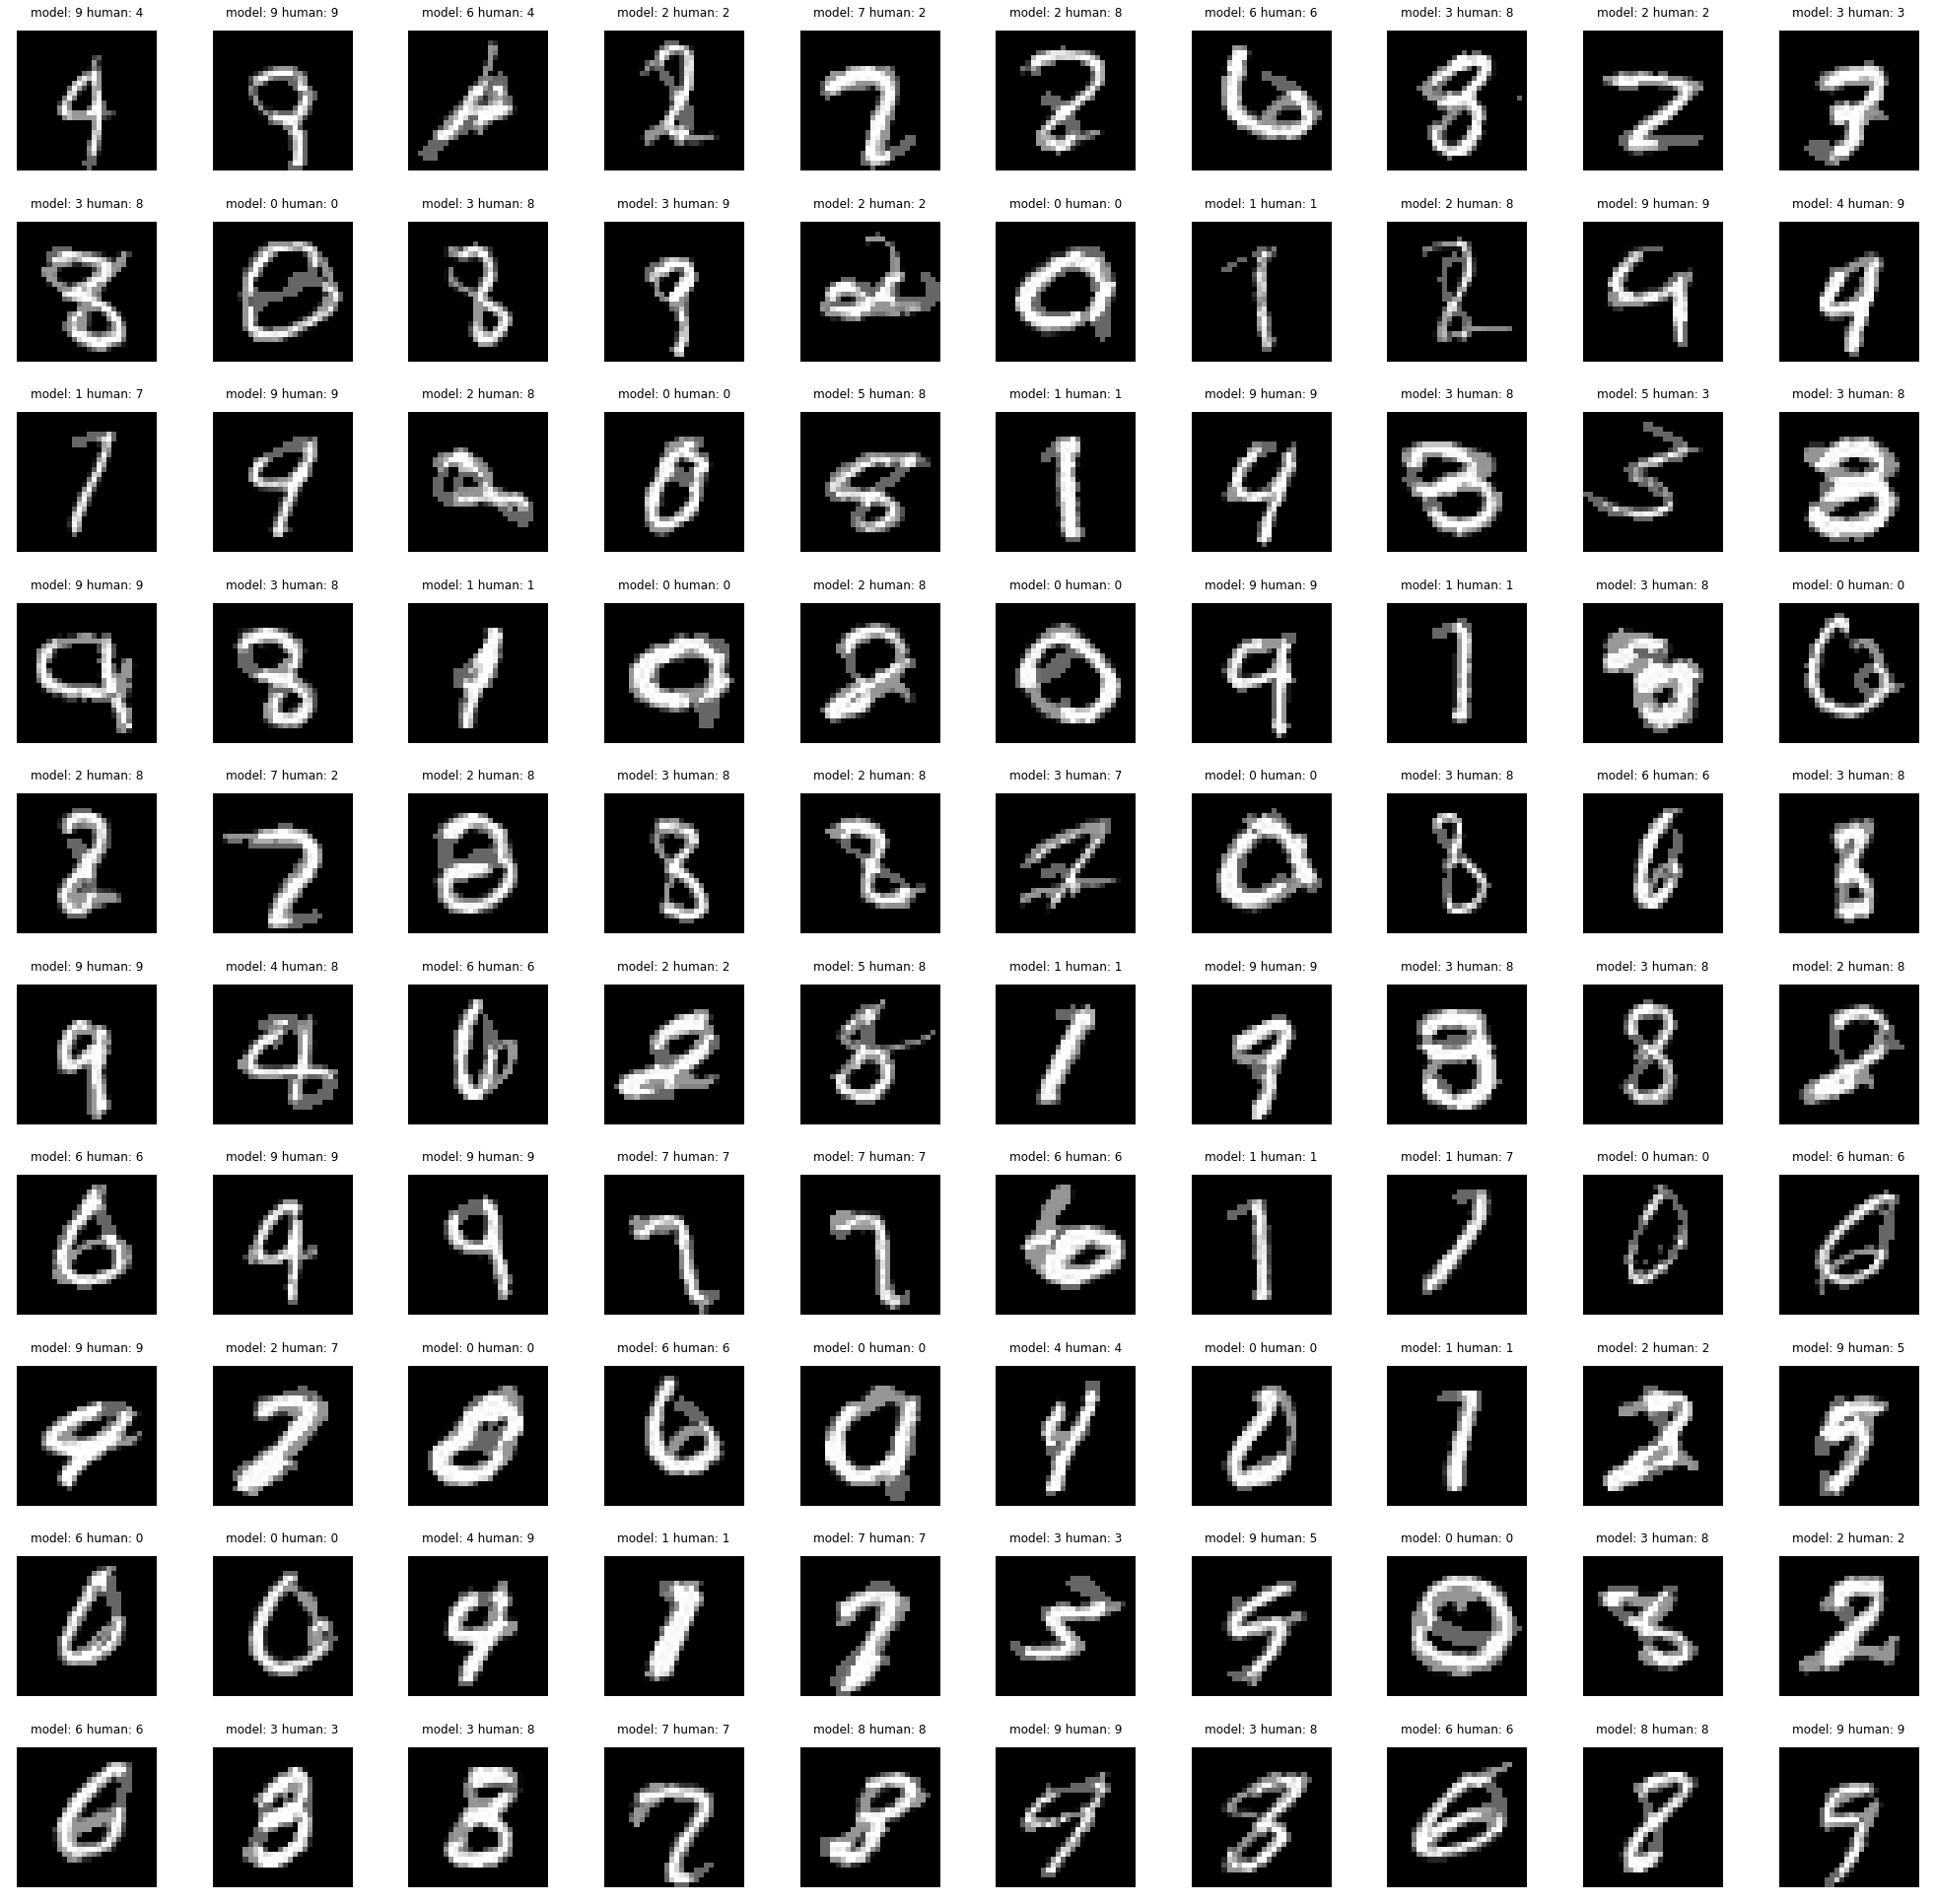

Human disagreeing: 41.0%


In [7]:
#Get model untrained with adversarial examples...
model=load_model("vanilla_model")


#get invariance-based adversarial examples generated from tramer et al.
adv_03 = np.load('invariance_examples/linf/automated_eps04.npy').astype(np.float32) / 255.
#get the human labels from tramer et.al
labels_h_03 = np.load('invariance_examples/linf/automated_eps04_labels.npy')

labels_h_03=to_categorical(labels_h_03)




print("INVARIANCE BASED ADVERSARIAL IMAGES")
disagreeing_human=0

#let my model predict with the invariance-based adversarial examples
predictions=model.predict(adv_03)
_, ax = plt.subplots(10, 10, figsize=(35, 35))
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=adv_03[i]
    # x=x[:,:,0]
    human_labeled=np.argmax(labels_h_03[i])
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title("model: {} human: {}".format(np.argmax(predictions[i]), human_labeled))
    #check if human prediction differs from model prediction
    if human_labeled!=np.argmax(predictions[i]):
        disagreeing_human+=1

plt.show()

print("Human disagreeing: {}%".format(disagreeing_human/100*100))



# Save random 200 indices in file...
Needed to generate invariance based adversarial examples

In [8]:
rand_indices = np.random.randint(0,9999,(200))
np.save("npy/random_indices200", rand_indices)





# Find nearest Neighbours (Takes a lot of computation)

In [9]:
from keras.datasets import mnist
import numpy as np
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift

#  Load the MNIST data. 100 randomly chosen test points
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200
test_xs = X_test[idxs]
test_ys = Y_test[idxs]

# build a nearest neighbors classifier per class
N = 1
all_NNs = []

for i in range(10):
    #Reshape to 1D (28*28=784)
    X = X_train[Y_train == i].reshape(-1, 784)
    print("X: ", np.shape(X))
    nn = NearestNeighbors(n_neighbors=N)
   
    nn.fit(X)
    all_NNs.append(nn)
print(all_NNs)



# Rotation-translation parameters
limits = [3, 3, 30]
granularity = [5, 5, 31]
grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))

# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


all_nns = []
all_y_nns = []
all_grids_nns = []

# find nearest neighbors for some test inputs (this takes a little while)
for i in range(len(idxs)):
    if i % 10 == 0:
        print("{}/{} done".format(i, len(idxs)))
    x = test_xs[i]
    y = test_ys[i]

    # find the nearest neighbors for each class, with the corresponding rotation and translation
    nns, y_nns, grids_nns = get_best_neighbors(x, y)
    nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
    all_nns.append(nn_advs)
    all_y_nns.append(y_nns)
    all_grids_nns.append(np.asarray(grids_nns))

X:  (5923, 784)
X:  (6742, 784)
X:  (5958, 784)
X:  (6131, 784)
X:  (5842, 784)
X:  (5421, 784)
X:  (5918, 784)
X:  (6265, 784)
X:  (5851, 784)
X:  (5949, 784)
[NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1)]
0/200 done
10/200 done
20/200 done
30/200 done
40/200 done
50/200 done


KeyboardInterrupt: 

# Save nearest Neighbours

In [ ]:
# save everything!
np.save("X_test_200.npy", test_xs)
np.save("all_nns.npy", np.asarray(all_nns))
np.save("all_y_nns.npy", np.asarray(all_y_nns))
np.save("all_grids_nns.npy", np.asarray(all_grids_nns))

print(np.shape(test_xs))

(200, 28, 28)


In [ ]:
def linf_attack(x, nn_adv, eps=0.3):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv

# Generate invariance based adversarial examples

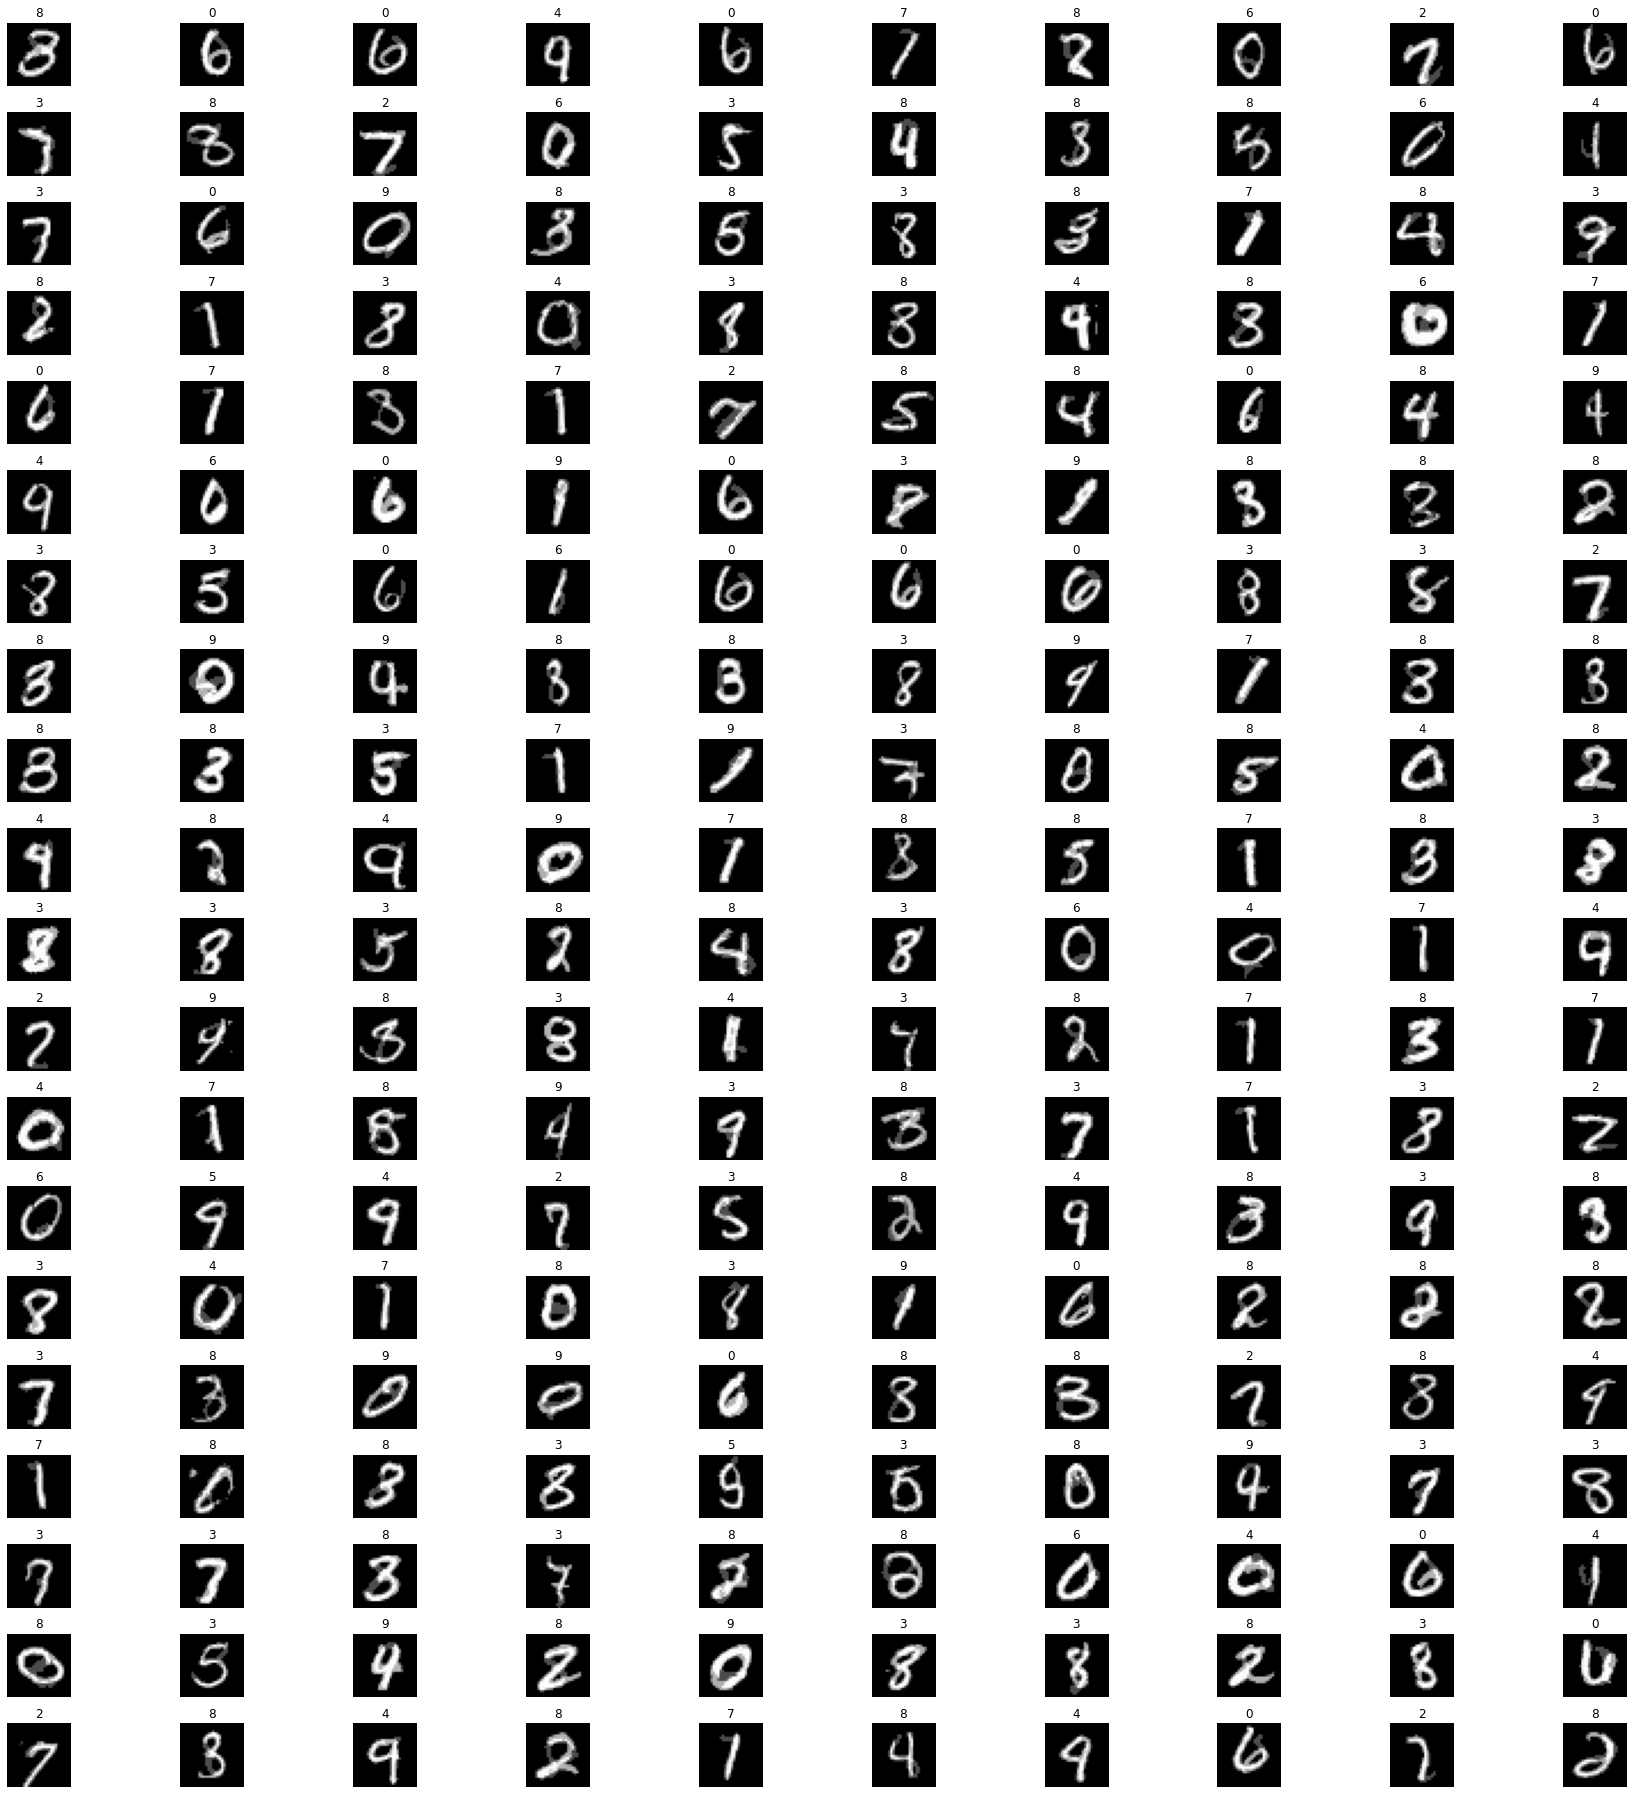

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
all_nns=np.load("all_nns.npy")
all_y_nns=np.load("all_y_nns.npy")
all_grids_nns=np.load("all_grids_nns.npy")
test_xs=np.load("X_test_200.npy")
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200

test_ys = Y_test[idxs]
# fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
#                        figsize=(10*2, len(all_nns)*1.5))
# [a.axis('off') for a in np.asarray(ax).reshape(-1)]

# manually chosen target classes for each source class
targets = {
    0: [4, 6, 8, 9],
    1: [4, 6, 7, 9],
    2: [8],
    3: [8],
    4: [8, 9],
    5: [3, 8],
    6: [0],
    7: [2, 3],
    8: [3],
    9: [3, 4, 5]
}

best_y_advs = []
best_targets = []
best_advs = []

for i in range(len(all_nns)):
    x = test_xs[i]
    y = test_ys[i]
    # ax[i, 0].imshow(255-x, cmap='gray', vmin=0, vmax=255)
    
    best_x_adv = None
    best_nn_adv = None
    amount_removed = []
    amount_added = []
    rot = []
    best_y = None
    min_removed = np.inf
    for j in range(len(all_nns[i])):
        nn_adv = all_nns[i][j]
        y_nn = all_y_nns[i][j]
        x_adv = linf_attack(x, nn_adv, eps=0.3)
        # ax[i, 1+y_nn].imshow(255-x_adv, cmap='gray', vmin=0, vmax=255)
        
        # retain the target that required the least amount of pixels to be "removed"
        curr_rot = np.abs(all_grids_nns[i][j][-1])
        curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
        
        if y_nn in targets[y] and curr_removed < min_removed:
            min_removed = curr_removed
            best_y = y_nn
            best_x_adv = x_adv
            best_nn_adv = (nn_adv, y_nn)
                
    best_targets.append(best_nn_adv)
    best_advs.append(best_x_adv)
    best_y_advs.append(best_y)
# print("BEST Y: ", np.shape(best_advs))
# print("BEST X: ",np.shape(best_y_advs))

_, ax = plt.subplots(20, 10, figsize=(25, 25))
j=0
for i in range(200):
    x=best_advs[i]
    if i>0:
        if i%10==0:
            j+=1
    # print("ax[{},{}]".format(j, i%10))
    
    ax[j, i%10].imshow(x,cmap='gray')
    ax[j, i%10].axis('off')
    ax[j,i%10].set_title(best_y_advs[i])
# for i in range(200):
#     temp = np.ones((32, 32, 3), dtype=np.float32)
#     x=best_advs[i]
#     # x=x[:,:,0]
#     # temp[2:-2, 2:-2, 0] = x
#     # temp[2:-2, 2:-2, 1] = x
#     # temp[2:-2, 2:-2, 2] = x
#     print("ax[{},{}]".format(i//20, i%10))
#     ax[i//20, i%10].imshow(x)
#     ax[i//20, i%10].axis('off')
_.tight_layout(pad=1.0)
plt.show()

np.save("npy/invariance-based_adversarial_examples", best_advs)
np.save("npy/invariance-based_adversarial_examples_labels", best_y_advs)
